If you are running this notebook on Google Colab, uncomment and run the following cell to install the required dependencies.

In [ ]:
# !pip install pgmpy==0.1.21 daft==0.1.2

In [1]:
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

This is a short notebook illustrating probabilistic graphical modelling (PMG) and inference on a car start Bayesian network [(Heckerman, 1995)](http://tomlr.free.fr/Math%E9matiques/Fichiers%20Claude/Auteurs/AAprov070125/Heckerman%20-%20A%20Tutorial%20On%20Learning%20Bayesian%20Networks.pdf):

![Heckerman's car start belief network](./figures/heckerman-car-model.png)

This is a simplified model for troubleshooting a car that won't start, where each node represents a variable and directed edges relate causes and effects. For simplicity, we will also assume that each variable is discrete and binary.

## Model

We will use [pgmpy](https://github.com/pgmpy/pgmpy) Python library to define the model and perform exact inference on the model.

Let us first initialise the PGM defined by the above DAG, and define the possible states.

In [2]:
car_model = BayesianNetwork(
    [
        ("Battery", "Gauge"),
        ("Fuel", "Gauge"),
        ("Fuel", "Start"),
        ("Turn Over", "Start"),
        ("Battery", "Turn Over"),
    ]
)

state_names = {
    "Battery":      ["Bad",     "Good"],
    "Fuel":         ["Empty",   "Not empty"],
    "Gauge":        ["Empty",   "Not empty"],
    "Turn Over":    ["No",      "Yes"],
    "Start":        ["No",      "Yes"],
}

We can now render the model into an image to verify that the representation is correct.

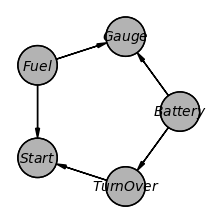

In [3]:
pgm_daft = car_model.to_daft()
pgm_daft.render()
plt.show()

Next we define the (conditional) probability tables as given in the figure at the top of the notebook:

* `variable_card` defines the cardinality of the variable
* `values` correspond to the (conditional) probabilities and must sum to 1
* `evidence` defines the variables in the conditioning set
* `evidence_card` denotes the cardinality of the variables in the conditioning set

In [4]:
pt_battery = TabularCPD(variable="Battery", 
                        variable_card=2,
                        values=[[0.02], [0.98]],
                        state_names=state_names)
pt_fuel = TabularCPD(variable="Fuel", 
                     variable_card=2, 
                     values=[[0.05], [0.95]],
                     state_names=state_names)

cpt_gauge = TabularCPD(
    variable="Gauge",
    variable_card=2,
    values=[[0.99, 0.1, 0.97, 0.04], 
            [0.01, 0.9, 0.03, 0.96]],
    evidence=["Battery", "Fuel"],
    evidence_card=[2, 2],
    state_names=state_names,
)

cpt_turnover = TabularCPD(
    variable="Turn Over",
    variable_card=2,
    values=[[0.98, 0.03], 
            [0.02, 0.97]],
    evidence=["Battery"],
    evidence_card=[2],
    state_names=state_names,
)

cpt_start = TabularCPD(
    variable="Start",
    variable_card=2,
    values=[[1.0, 1.0, 0.92, 0.01], 
            [0.0, 0.0, 0.08, 0.99]],
    evidence=["Turn Over", "Fuel"],
    evidence_card=[2, 2],
    state_names=state_names,
)

We can print the (conditional) probability tables that we have created just now:

In [5]:
print(pt_battery.variable, pt_battery._make_table_str(), sep='\n'); print()
print(pt_fuel.variable, pt_fuel._make_table_str(), sep='\n'); print()
print(cpt_gauge.variable, cpt_gauge._make_table_str(), sep='\n'); print()
print(cpt_turnover.variable, cpt_turnover._make_table_str(), sep='\n'); print()
print(cpt_start.variable, cpt_start._make_table_str(), sep='\n'); print()

Battery
-------------  ----
Battery(Bad)   0.02
Battery(Good)  0.98
-------------  ----

Fuel
---------------  ----
Fuel(Empty)      0.05
Fuel(Not empty)  0.95
---------------  ----

Gauge
----------------  ------------  ---------------  -------------  ---------------
Battery           Battery(Bad)  Battery(Bad)     Battery(Good)  Battery(Good)
Fuel              Fuel(Empty)   Fuel(Not empty)  Fuel(Empty)    Fuel(Not empty)
Gauge(Empty)      0.99          0.1              0.97           0.04
Gauge(Not empty)  0.01          0.9              0.03           0.96
----------------  ------------  ---------------  -------------  ---------------

Turn Over
--------------  ------------  -------------
Battery         Battery(Bad)  Battery(Good)
Turn Over(No)   0.98          0.03
Turn Over(Yes)  0.02          0.97
--------------  ------------  -------------

Start
----------  -------------  ---------------  --------------  ---------------
Turn Over   Turn Over(No)  Turn Over(No)    Turn Over(Yes) 

Now, we associate the Bayesian network with the (conditional) probability tables, and verify that the model is valid (i.e. probabilities sum to one, and the evidence variables are consistent with the model).

In [6]:
# Associating the parameters with the model structure.
car_model.add_cpds(pt_battery, pt_fuel, cpt_gauge, cpt_turnover, cpt_start)

# Checking if the cpts are valid for the model.
car_model.check_model()

True

## Inference

We can now perform inference on the Bayesian network `car_model`.

To do so we will use [variable elimination](https://en.wikipedia.org/wiki/Variable_elimination).



Let us first ask what is the marginal probability that the car will start, which means we must eliminate all the variables that are not `"Start"`. That is we want to know $p(Start)$.

In [7]:

car_inference = VariableElimination(car_model)

q = car_inference.query(variables=["Start"])
print(q)

+------------+--------------+
| Start      |   phi(Start) |
+============+==============+
| Start(No)  |       0.1018 |
+------------+--------------+
| Start(Yes) |       0.8982 |
+------------+--------------+


It turns out our car is not very great since it doesn't start over 10\% of the time!

Now let's say the card is not starting, what is the probability that there is an issue with the battery? That is we want to know $p(Battery \mid Start=\text{No})$.

In [8]:
q = car_inference.query(variables=["Battery"], evidence={"Start": "No"})
print(q)

+---------------+----------------+
| Battery       |   phi(Battery) |
+===============+================+
| Battery(Bad)  |         0.1928 |
+---------------+----------------+
| Battery(Good) |         0.8072 |
+---------------+----------------+


So there is still a good chance that the battery is still good. Then, what is the state of our fuel tank given that the car did not start, i.e. $p(Fuel \mid Start= \text{No})$? 

In [9]:
q = car_inference.query(variables=["Fuel"], evidence={"Start": "No"})
print(q)

+-----------------+-------------+
| Fuel            |   phi(Fuel) |
+=================+=============+
| Fuel(Empty)     |      0.4539 |
+-----------------+-------------+
| Fuel(Not empty) |      0.5461 |
+-----------------+-------------+


Given our model, it seems like the chance that the fuel tank is empty is almost a coin toss.

We can also ask queries about multiple variables at the time, for example $p(Battery, Fuel \mid Start=\text{No})$:

In [10]:
q = car_inference.query(variables=["Battery", "Fuel"], evidence={"Start": "No"})
print(q)

+---------------+-----------------+---------------------+
| Battery       | Fuel            |   phi(Battery,Fuel) |
+===============+=================+=====================+
| Battery(Bad)  | Fuel(Empty)     |              0.0098 |
+---------------+-----------------+---------------------+
| Battery(Bad)  | Fuel(Not empty) |              0.1830 |
+---------------+-----------------+---------------------+
| Battery(Good) | Fuel(Empty)     |              0.4441 |
+---------------+-----------------+---------------------+
| Battery(Good) | Fuel(Not empty) |              0.3631 |
+---------------+-----------------+---------------------+


Hence, given that our car didn't start, it seems most likely that our fuel tank is empty followed by a sporadic chance of our car failing to start for some other reasons. 

## Independencies

We can also get a list of more general properties of our car in the form of an independencies. For example, Given the state of the battery we know that the state of the "Gauge" and "Turn Over" are conditionally independent. 

In [11]:
car_model.get_independencies()

(Battery ⟂ Fuel)
(Battery ⟂ Fuel, Start | Turn Over)
(Battery ⟂ Start | Turn Over, Fuel)
(Battery ⟂ Fuel | Turn Over, Start)
(Battery ⟂ Start | Turn Over, Gauge, Fuel)
(Fuel ⟂ Turn Over, Battery)
(Fuel ⟂ Battery | Turn Over)
(Fuel ⟂ Turn Over | Battery)
(Fuel ⟂ Battery | Turn Over, Start)
(Fuel ⟂ Turn Over | Battery, Gauge)
(Turn Over ⟂ Fuel)
(Turn Over ⟂ Gauge, Fuel | Battery)
(Turn Over ⟂ Fuel | Battery, Gauge)
(Turn Over ⟂ Gauge | Battery, Fuel)
(Turn Over ⟂ Gauge | Battery, Fuel, Start)
(Gauge ⟂ Turn Over | Battery)
(Gauge ⟂ Start | Turn Over, Fuel)
(Gauge ⟂ Turn Over, Start | Battery, Fuel)
(Gauge ⟂ Start | Turn Over, Battery, Fuel)
(Gauge ⟂ Turn Over | Battery, Fuel, Start)
(Start ⟂ Battery | Turn Over)
(Start ⟂ Battery, Gauge | Turn Over, Fuel)
(Start ⟂ Gauge | Battery, Fuel)
(Start ⟂ Gauge | Turn Over, Battery, Fuel)
(Start ⟂ Battery | Turn Over, Gauge, Fuel)